## Dependencis
import dependencis required to run & train our model + record a video

In [1]:
import gym
import imageio
import numpy as np
import base64
import IPython
import PIL.Image

# Video stuff 
from pathlib import Path
from IPython import display as ipythondisplay

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import VecVideoRecorder, SubprocVecEnv, DummyVecEnv
from stable_baselines import PPO2

/Users/Aswin_Shriram_T/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Aswin_Shriram_T/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Aswin_Shriram_T/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Aswin_Shriram_T/opt/anaconda3/lib

In [2]:
import os
from stable_baselines.bench import Monitor

In [3]:
path = os.path.join( os.getcwd(), '..' )
model_save_path = path + '/Model Archive/'
results_save_path = path + '/Results/'

In [4]:
print(path)
print(model_save_path)
print(results_save_path)

/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/PPO_LLC/Code/..
/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/PPO_LLC/Code/../Model Archive/
/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/PPO_LLC/Code/../Results/


In [ ]:
path

In [ ]:
model_save_path

In [ ]:
results_save_path

## Define variables & functions
Here we define our variables and also create a couple of functions 

In [ ]:
# set enviorment variables that we will use in our code
env_id = 'LunarLanderContinuous-v2'
video_folder = results_save_path + '/videos'
video_length = 100

log_dir = results_save_path + "tmp/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make(env_id)
# set our inital enviorment
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])
obs = env.reset()

In [ ]:
# Evaluation Function
def evaluate(model, num_steps=1000):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_steps: (int) number of timesteps to evaluate it
    :return: (float) Mean reward for the last 100 episodes
    """
    episode_rewards = [0.0]
    obs = env.reset()
    for i in range(num_steps):
        # _states are only useful when using LSTM policies
        action, _states = model.predict(obs)

        obs, reward, done, info = env.step(action)

        # Stats
        episode_rewards[-1] += reward
        if done:
            obs = env.reset()
            episode_rewards.append(0.0)
    # Compute mean reward for the last 100 episodes
    mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
    print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))

    return mean_100ep_reward

In [ ]:
# Record video
def record_video(env_id, model, video_length=500, prefix='', video_folder=video_folder):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id)])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

# Define & Configure out Reinforcment learning algoritm 
In this example we are using default PPO2 / Proximal Policy Optimization. Read more about how you define your PPO2 [parameters](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html#parameters) 

In [ ]:
# Define the model
model = PPO2(MlpPolicy, env, verbose=2, tensorboard_log="./ppo_tb_log") # add & tweak default parameters, messure your output & improve link to parameters above (it will however work with default)

## Train model 50k steps & evaluate results
Here we train, evaluate, save, record & display video

In [ ]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_steps=10000)

In [ ]:
%load_ext tensorboard

In [ ]:
!tensorboard --logdir ./ppo_tb_log

In [ ]:
model = PPO2.load(model_save_path + 'ppo_{}_weights_1000000.pkl'.format(env_id))

In [ ]:
# Random Agent, after training
mean_reward_after_train = evaluate(model, num_steps=1500)

In [ ]:
# # Record & show video
record_video(env_id, model, video_length=1500, prefix='ppo_{}_results_test'.format(env_id))

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
def video_saver(filename, agent=model, env=env, num_epi=5, path_save = results_save_path+'Videos/'):
    rec = VideoRecorder(env, path = path_save+filename, enabled=True)
    rec.capture_frame()
    for i_episode in range(num_epi):
        rec.capture_frame()
        observation = env.reset()
        for t in range(1000):
            env.render()
            #print(observation)
            #action = agent.actor.predict(observation.reshape(1,1,env.observation_space.shape[0]))
            action = agent.predict(observation.reshape(1,env.observation_space.shape[0]))
            #print(action)
            observation, reward, done, info = env.step(action[0])
            rec.capture_frame()
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                print("Reward at the end of episode {} :".format(i_episode+1), reward)
                break
    rec.close()
    env.close()

In [ ]:
video_saver('ppo2_{}_results_test.mp4'.format(env_id))

In [ ]:
# Evaluation Function
def test_evaluate(model, num_steps=1000):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_steps: (int) number of timesteps to evaluate it
    :return: (float) Mean reward for the last 100 episodes
    """
    episode_rewards = [0.0]
    episode = [1]
    obs = env.reset()
    for i in range(num_steps):
        # _states are only useful when using LSTM policies
        action, _states = model.predict(obs)

        obs, reward, done, info = env.step(action)

        # Stats
        episode_rewards[-1] += reward
        if done:
            obs = env.reset()
            print(episode_rewards[-1])
            episode_rewards.append(0.0)
            episode.append(len(episode)+1)
    # Compute mean reward for the last 100 episodes
#     mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
#     print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
    #print(episode_rewards, len(episode_rewards))

    return {"episode_rewards": episode_rewards, "episode_num": episode}

In [ ]:
test_result = test_evaluate(model, 50000)

In [ ]:
test_result

In [5]:
import pandas as pd

In [ ]:
test = dict()

In [ ]:
test['episode_rewards'] = [i[0] for i in test_result['episode_rewards']]

In [ ]:
test['episode_num'] = [i for i in test_result['episode_num']]

In [ ]:
pd.DataFrame(test).to_csv(results_save_path+'ppo_{}_results_test.csv'.format(env_id))

In [6]:
import json

In [7]:
import matplotlib.pyplot as plt

In [8]:
plt.rcParams['figure.figsize'] = 15, 10

In [15]:
model_results_df = pd.read_csv(results_save_path+'run-PPO2_1-tag-episode_reward.csv')
model_results_df.reset_index(inplace=True)
model_results_df.columns = ['episode', 'Wall time', 'Step', 'episode_reward']

In [16]:
analyze_df = model_results_df.copy()
analyze_df['episode'] +=1
# analyze_df['avg_reward_per_episode-step'] = analyze_df['episode_reward']/analyze_df['nb_episode_steps']

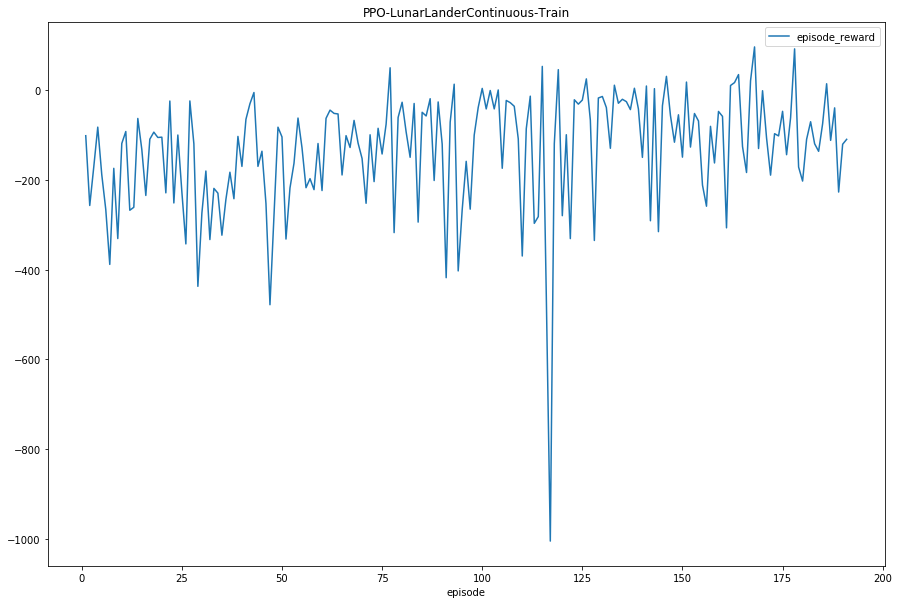

In [17]:
analyze_df.set_index(['episode'])[['episode_reward']].plot()
plt.title('PPO-LunarLanderContinuous-Train')
plt.savefig(results_save_path+'train_rewards.png', dpi=400, bbox_inches='tight')

In [18]:
test_df = pd.read_csv(results_save_path+'ppo_LunarLanderContinuous-v2_results_test.csv')
test_df['Unnamed: 0'] +=1
test_df.columns = ['episode', 'episode_reward', 'nb_steps']

In [19]:
test_df.columns

Index(['episode', 'episode_reward', 'nb_steps'], dtype='object')

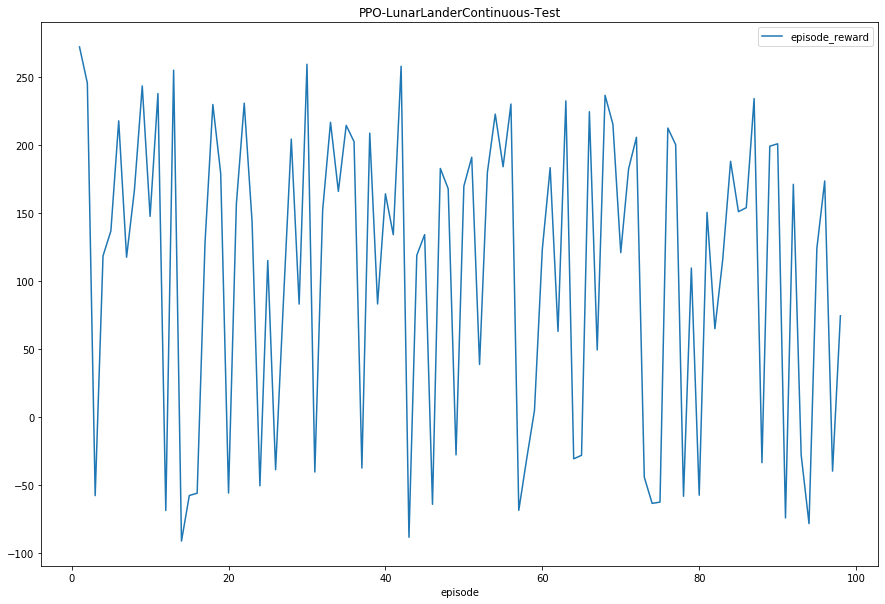

In [21]:
test_df.set_index(['episode'])[['episode_reward']].plot()
plt.title('PPO-LunarLanderContinuous-Test')
plt.savefig(results_save_path+'test_rewards.png', dpi=400, bbox_inches='tight')